# Compare match distance distribution to random
Set yout settings in the first cell

In [1]:
match_cat = "gaiadr3"  # Works for "simbad" or "gaiadr3"
region_name = "ALL_10-800" #"CAINGSGII_10-800"  #"TDS" #"CAINGSGII_10-800"  #"TDS" # "MDIS_10-800" # "TDS" # _ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
region_cat_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"
region_fname_rnd = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat_rnd.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
from astropy.table import unique, Table, hstack, join, setdiff
from astropy import units as uu
from astroquery.simbad import Simbad
from astropy.visualization import quantity_support
from astropy.modeling.models import BlackBody
from astropy import constants as cc
from matplotlib.ticker import ScalarFormatter
from astroquery.sdss import SDSS

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, dd_filter2wavelength, mag2flux, flux2mag, query_vizier_sed, add_ogrp

from loguru import logger
logger.enable("vasca")



# Do catalog file
rc = Region()
rc.load_from_fits(region_cat_fname)
rc.copy_table_columns("tt_sources","tt_"+match_cat,["match_distance"],"rg_src_id")
#rc.tt_sources.rename_column("match_distance","match_distance_simbad")
matches = rc.tt_sources[match_cat+"_match_id"]>-0.5
nr_matches = matches.sum()
print("Number of sources and matches:",len(rc.tt_sources),nr_matches)
#display(rc.tt_sources)

2024-01-02 15:53:02.802 | DEBUG    | vasca.tables:load_from_fits:328 - Loading file with name './vasca_pipeline/ALL_10-800/region_ALL_10-800_cat.fits'
2024-01-02 15:53:02.810 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_fields'
2024-01-02 15:53:02.822 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_filters'
2024-01-02 15:53:02.827 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_visits'
2024-01-02 15:53:02.834 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_sources'
2024-01-02 15:53:02.854 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_detections'
2024-01-02 15:53:02.876 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_detections'
2024-01-02 15:53:02.943 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_sources'
2024-01-02 15:53:02.967 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_src_id_map'
2024-01-02 15:53:02.977 | DEBUG    | vasca.tab

Number of sources and matches: 4202 3302


In [3]:
#Random shifts
ll_match_dist = []
nr_sims = 5
for ii in range(nr_sims):
    rg = Region()
    rg.load_from_fits(region_fname) 
    rc_rnd = rg.get_region_catalog()
    nr_src = len(rc.tt_sources)
    shift_dist = 60 # in arcsec
    rng = np.random.default_rng(ii)
    ra_random = rng.uniform(-shift_dist, shift_dist, nr_src) * uu.arcsec
    dec_random = rng.uniform(2, shift_dist, nr_src) * uu.arcsec
    dec_random_sign = np.sign(rng.uniform(-1, 1, nr_src))
    
    rc_rnd.tt_sources["dec"]=rc.tt_sources["dec"].quantity+dec_random_sign*dec_random.to(uu.deg)
    rc_rnd.tt_sources["ra"]=rc.tt_sources["ra"].quantity+ra_random.to(uu.deg)*np.cos(rc.tt_sources["dec"].quantity)
    if match_cat=="simbad":
        rc_rnd.cross_match_cds(query_table=match_cat, overwrite=True)
    else:
        rc_rnd.cross_match_cds(overwrite=True)
    ll_match_dist.extend(list(rc_rnd.__dict__["tt_"+ match_cat]["match_distance"]))

2024-01-02 15:53:03.233 | DEBUG    | vasca.tables:load_from_fits:328 - Loading file with name './vasca_pipeline/ALL_10-800/region_ALL_10-800.fits'
2024-01-02 15:53:03.238 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_fields'
2024-01-02 15:53:03.255 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_filters'
2024-01-02 15:53:03.271 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_visits'
2024-01-02 15:53:03.296 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_sources'
2024-01-02 15:53:03.816 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_detections'
2024-01-02 15:53:05.035 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_detections'
2024-01-02 15:53:05.100 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_sources'
2024-01-02 15:53:05.285 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_src_id_map'
2024-01-02 15:53:05.308 | DEBUG    | vasca.region:

Total Nr. matches: 3302 14.8
Mean distance: 0.40054348 1.015080381209021


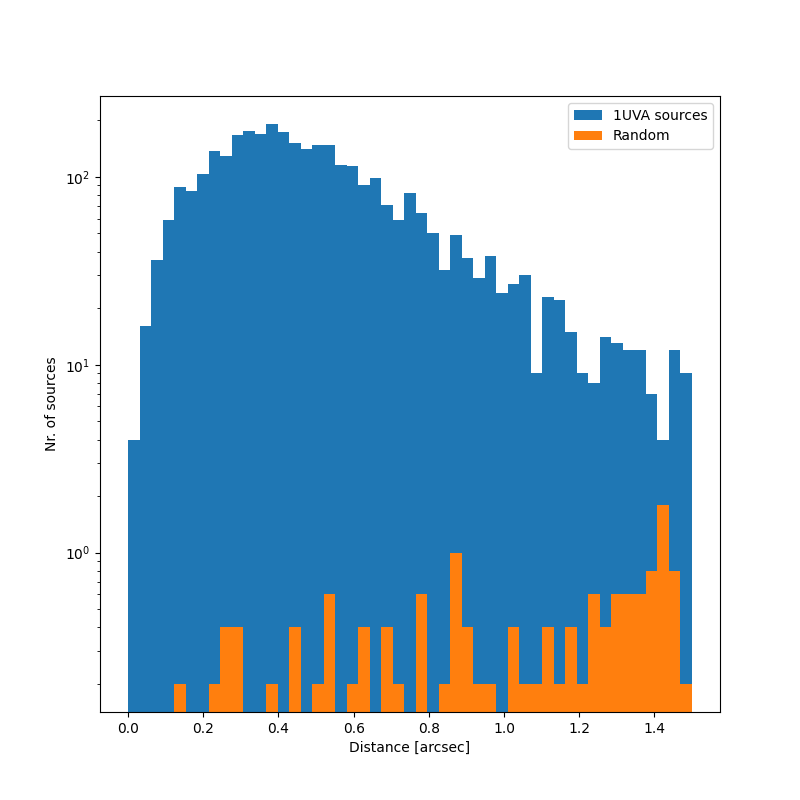

In [5]:
tt_name = "tt_match_dist_rnd_"+match_cat+"_"+str(nr_sims)+".fits"
tt_dist = Table()
tt_dist["match_dist"] = ll_match_dist
tt_dist.write(tt_name)

dist_bins = np.linspace(0,1.5,50)
fig, ax = plt.subplots(1, 1, figsize=(8, 8), clear=True)
_ = ax.hist(rc.tt_sources["match_distance"], bins=dist_bins, label="1UVA sources")
_ = ax.hist(ll_match_dist, bins=dist_bins, weights=(1./nr_sims)*np.ones(len(ll_match_dist)), label="Random")
ax.set_yscale("log")
ax.set_xlabel("Distance [arcsec]")
ax.set_ylabel("Nr. of sources")
ax.legend()
fig.savefig("match_distance_"+match_cat+".pdf")

print("Total Nr. matches:",nr_matches, len(ll_match_dist)/float(nr_sims))
print("Mean distance:",np.mean(matches*rc.tt_sources["match_distance"]),np.mean(ll_match_dist))